In [85]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pickle
from PIL import Image

import matplotlib.pyplot as plt
import hmax
import numpy as np
import pandas as pd

In [111]:
#test data download
eye_movements_df = pd.read_excel('./data/eye_movements/sample_data1(dynamics).xlsx', decimal='\t')

x = np.array(eye_movements_df['Point of Regard Right X [px]'])
y = np.array(eye_movements_df['Point of Regard Right Y [px]'])

x = np.split(x, np.where(x == '-')[0])
y = np.split(x, np.where(y == '-')[0])

C:\Users\arsen\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [2]:
model = hmax.HMAX('./universal_patch_set.mat')

In [50]:
# A folder with example images
example_images = datasets.ImageFolder(
    './example_images/',
    transform=transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x * 255),
    ])
)

# A dataloader that will run through all example images in one batch
dataloader = DataLoader(example_images, batch_size=20)


In [4]:
torch.cuda.is_available()

False

In [5]:
# Determine whether there is a compatible GPU available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
# Run the model on the example images
#s2: 1st neuron; 2nd image; 3rd filter; 4th (64,64) picture;
model = model.to(device)
for X, y in dataloader:
    s1, c1, s2, c2 = model.get_all_layers(X.to(device))


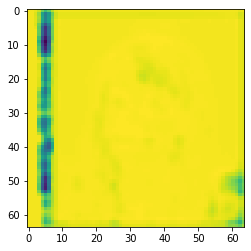

In [26]:
plt.imshow(s2[0][0][9][370])

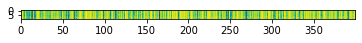

In [28]:
plt.imshow(c2[2])

In [ ]:
with open('output.pkl', 'wb') as f:
    pickle.dump(dict(s1=s1, c1=c1, s2=s2, c2=c2), f)

In [60]:
images_df = np.zeros((len(example_images),example_images[0][0][0].shape[0],example_images[0][0][0].shape[1]))
for i in range(len(example_images)):
    images_df[i,:,:] = example_images[i][0][0]

In [81]:
def pic_transform(im_df, image_param):

     new_images = np.zeros((im_df.shape[0],image_param+im_df.shape[1],image_param+im_df.shape[2]))
     for i in range(im_df.shape[0]):
         new_images[i,image_param//2:image_param//2+im_df.shape[1],image_param//2:image_param//2+im_df.shape[2]] = im_df[i,:,:]
     return new_images

def image_move(new_images, x, y):
    
    return 

In [82]:
new_images = pic_transform(images_df, 1000)

In [117]:
x[1]

array(['-', 1616.4, 1615.9, 1611.4, 1612.6, 1614.6, 1613.9, 1608.8,
       1608.8, 1611.2, 1608.4, 1608.7, 1605.9, 1603.5, 1605.1, 1603.9,
       1602.1, 1599.4, 1603.8, 1604.9, 1604.4, 1604, 1605, 1603.7, 1605.4,
       1603.7, 1603.6, 1606.3, 1606.8, 1606.5, 1605.2, 1604.6, 1604.9,
       1604, 1604, 1603.4, 1601.7, 1603.2, 1604.1, 1603.2, 1603, 1601.8,
       1601.9, 1602.9, 1603.3, 1603.6, 1606.8, 1607.3, 1606, 1606.2, 1607,
       1607.1, 1607.6, 1607.7, 1605.9, 1604.6, 1604.6, 1605.6, 1601.8,
       1603.8, 1602.8, 1602.8, 1603.7, 1604.6, 1604.4, 1605.2, 1605.7,
       1607.9, 1607.1, 1608.1, 1610.3, 1610.6, 1610.8, 1610.7, 1609.9,
       1610.7, 1610.3, 1611.3, 1610.9, 1612.2, 1612.2, 1612.6, 1611.6,
       1611.6, 1614.1, 1615.8, 1612.5, 1615.4, 1616.8, 1616, 1612.3,
       1616.3, 1612.1, 1611.8, 1613.7, 1610.9, 1610.7, 1614.7, 1613.5,
       1611.9, 1611.5, 1613.2, 1611.8, 1611.7, 1611.2, 1608.3, 1608.6,
       1604.7, 1604.5, 1602, 1596.7, 1582.2, 1496, 1465.6, 1431.9, 1383,